In [16]:
%matplotlib inline 
import sys
import os
import statistics
 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
# Need to upgrade scikit-learn: 0.16.1-np110py34_0 --> 0.17-np110py34_1
from sklearn.cross_validation import cross_val_score

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from mpl_toolkits.mplot3d import Axes3D

In [17]:
# fill in na according to their labels
def fillna(df, label, num_NA):
    df_sub = df[df['Y'] == label]
    index = df_sub.isnull().sum(axis=1) <= num_NA
    df_sub = df_sub[index]
    df_sub = df_sub.fillna(df_sub.median())
    return df_sub

# Deal with input data
trainX = pd.read_csv('trainingData.txt','\t', header = None)
trainX.drop(trainX.columns[len(trainX.columns)-1], axis = 1, inplace = True)
repr_trainX = trainX.copy(deep=True)

trainY = pd.read_csv("trainingTruth.txt", header = None, names = ['Y'])

# Fill NA
df = pd.concat([trainX, trainY], axis=1)
df1 = fillna(df, 1, num_NA = 0)
df2 = fillna(df, 2, num_NA = 0)
df3 = fillna(df, 3, num_NA = 0)
df = pd.concat([df1, df2, df3])

X = df.iloc[:,0:-1].values
Y = df['Y'].values


Darker colors are NAs.


/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


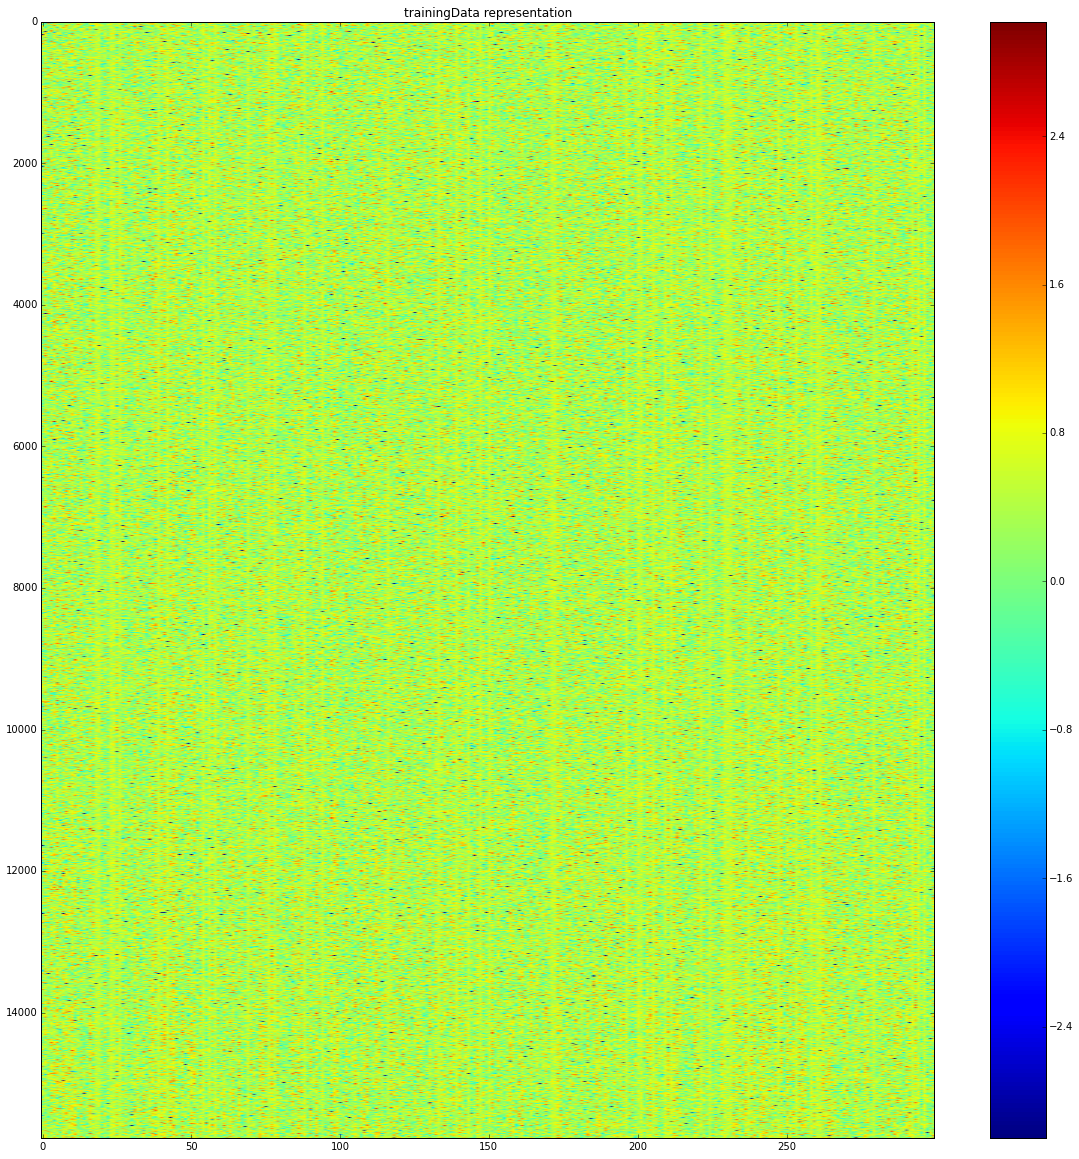

In [11]:
print ("Darker colors are NAs.")
repr_trainX = repr_trainX.fillna(-3)
fig, ax = plt.subplots(figsize=(20,20))
ax_imshow = ax.imshow(repr_trainX, aspect='auto')
fig.colorbar(ax_imshow)
plt.title('trainingData representation')
plt.show()


In [18]:
testX = pd.read_csv('testData.txt','\t', header = None)
testX.drop(testX.columns[len(testX.columns)-1], axis = 1, inplace = True)

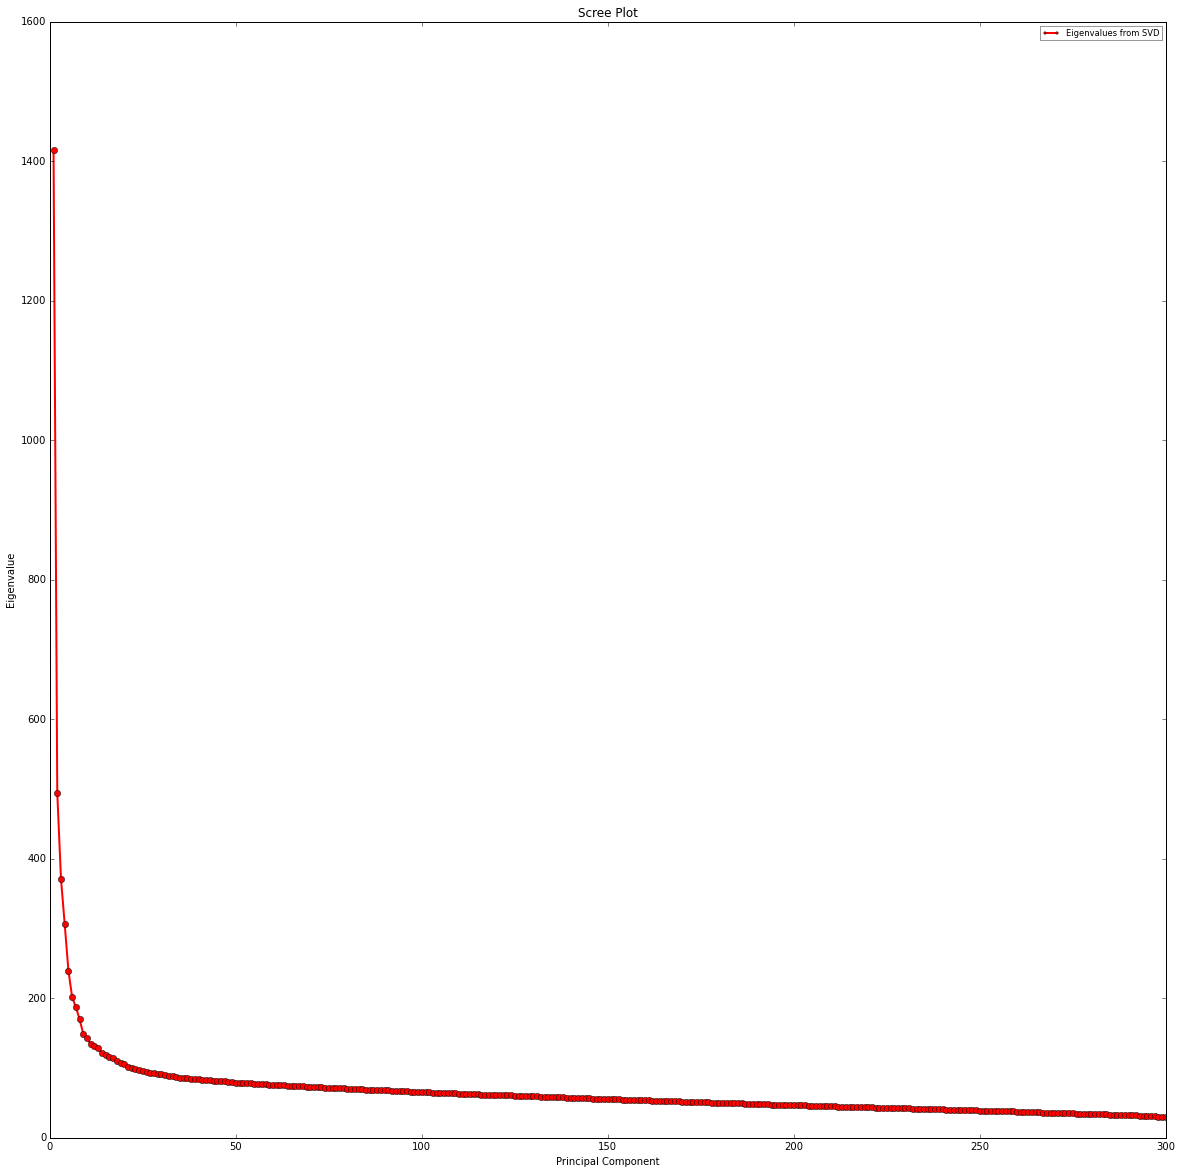

/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


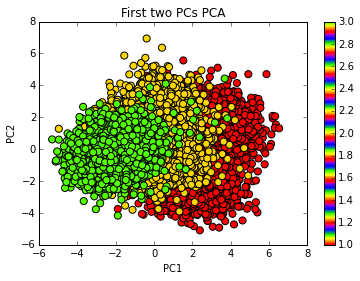

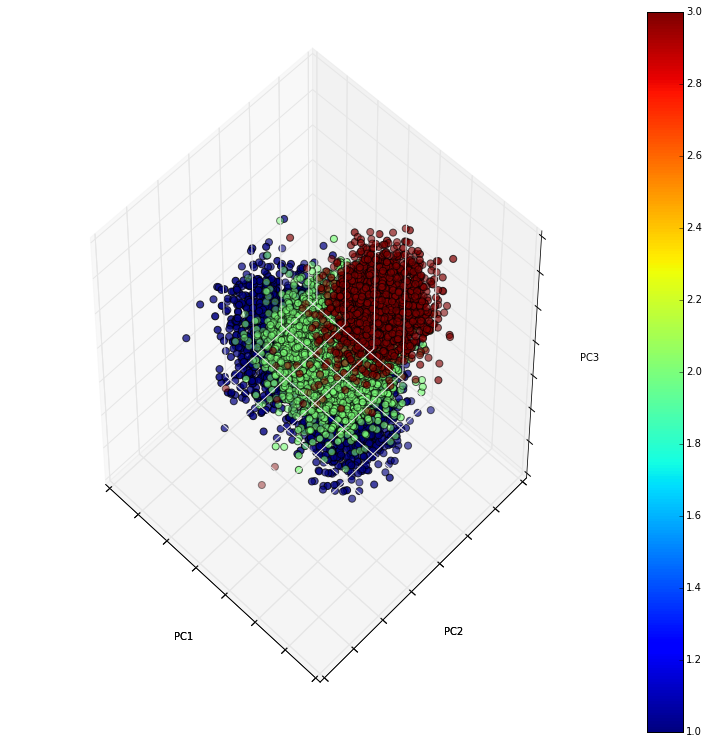

In [19]:
def print3D(X, title, labels):
    fig = plt.figure(1, figsize=(11, 10))
    plt.title(title)
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    
    ax_scatter = ax.scatter(X[:, 1], X[:, 0], X[:, 2], c=labels.astype(np.float), s=50)
    ax.dist = 11

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    fig.colorbar(ax_scatter)
    
def print2D(X, title, labels):
    plt.scatter(X[:,0], X[:,1], c=labels, s = 50, cmap=plt.cm.prism)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.colorbar()
    plt.show()

def printScreePlot(X):
    num_vars = 300
    X = np.asmatrix(X.T) * np.asmatrix(X)
    U, S, V = np.linalg.svd(X) 
    eigvals = S**2 / np.cumsum(S)[-1]

    fig = plt.figure(figsize=(20,20))
    sing_vals = np.arange(num_vars) + 1
    plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    #I don't like the default legend so I typically make mine like below, e.g.
    #with smaller fonts and a bit transparent so I do not cover up data, and make
    #it moveable by the viewer in case upper-right is a bad place for it 
    leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                     shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)
    leg.draggable(state=True)
    plt.show()
    
def trainingVisualization(trainX, trainY):
    
    n_train = len(trainX)
    n_test = len(testX)
    
    X = np.concatenate((trainX, testX), axis=0)
    X = preprocessing.scale(X)
    printScreePlot(X)
    
    X = np.concatenate((trainX, testX), axis=0)
    X = preprocessing.scale(X)
    X = PCA(n_components=2).fit_transform(X)
    X = X[0:n_train]
    print2D(X, 'First two PCs PCA', Y)
    
    X = np.concatenate((trainX, testX), axis=0)
    X = preprocessing.scale(X)
    X = PCA(n_components=3).fit_transform(X)
    X = X[0:n_train]   
    print3D(X, 'First three PCs PCA', Y)

trainingVisualization(X, testX)


In [20]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1, n_estimators=20)
clf3 = GaussianNB()

clf4 = DecisionTreeClassifier(max_depth=4)
clf5 = KNeighborsClassifier(n_neighbors=7)
clf6 = SVC(kernel='rbf', probability=True)
clf7 = AdaBoostClassifier(random_state=1)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),
                                     ('dt', clf4), ('kn', clf5), ('svc', clf6),
                                     ('ab', clf7)], voting='soft')


In [25]:
# Cross validation
from sklearn.cross_validation import ShuffleSplit,KFold
from sklearn.metrics import roc_curve, auc

# X = trainX.values
# Y = np.ravel(trainY.values)

def CV_auc(X, Y, clf):
    
    ss = ShuffleSplit(n=len(Y), n_iter=10, test_size=0.2, random_state=1)
    kf = KFold(len(Y), n_folds=10)

    scores = []
    roc_auc_scores = []
    
    for train, test in ss:
        print ("each")
        
        clf = clf.fit(X[train], Y[train])
        results = clf.predict(X[test])
        score = accuracy_score(Y[test], results)
        scores.append(score)

        probas = clf.predict_proba(X[test])


        roc_auc = np.zeros((3,1))
        for i in range(1,4):
            false_positive_rate, recall, thresholds = roc_curve(Y[test], probas[:,i-1], pos_label=i)
            roc_auc[i-1] = auc(false_positive_rate, recall)
        roc_auc_scores.append(roc_auc)
    
    print(np.mean(scores),np.std(scores))
    print(np.mean(roc_auc_scores, axis = 0))

In [22]:
for clf in [clf1, clf2, clf3, clf4, clf5, clf6]:
    print(clf)
    CV_auc(X, Y, clf)
    
print ("done")


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.840461095101 0.00765855227291
[[ 0.96126376]
 [ 0.91961394]
 [ 0.95909179]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
0.646397694524 0.0105280050713
[[ 0.86844501]
 [ 0.74294556]
 [ 0.84489359]]
GaussianNB()
0.856368876081 0.00691546583146
[[ 0.96834459]
 [ 0.93960504]
 [ 0.96715904]]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
     

In [26]:
# pip install scikit-neuralnetwork
# http://scikit-neuralnetwork.readthedocs.org/en/latest/index.html
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Maxout", units=100, pieces=2),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=25)

print(nn)
CV_auc(X, Y, nn)
print("done")


Classifier(batch_size=1, debug=False, dropout_rate=None, f_stable=0.001,
      hidden0=<sknn.nn.Layer `Maxout`: units=100, name='hidden0', pieces=2, frozen=False>,
      layers=[<sknn.nn.Layer `Maxout`: units=100, name='hidden0', pieces=2, frozen=False>, <sknn.nn.Layer `Softmax`: name='output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule='sgd',
      loss_type=None, mutator=None, n_iter=25, n_stable=10,
      output=<sknn.nn.Layer `Softmax`: name='output', frozen=False>,
      random_state=None, regularize=None, valid_set=None, valid_size=0.0,
      verbose=None, warning=None, weight_decay=None, weights=None)
each
each
each
each
each
each
each
each
each
each
0.951296829971 0.0636042053491
[[ 0.99221174]
 [ 0.98164002]
 [ 0.9887433 ]]
done


In [27]:
nn = Classifier(
    layers=[
        Layer("Maxout", units=100, pieces=2),
        Layer("Sigmoid")],
    learning_rate=0.001,
    n_iter=25)

print(nn)
CV_auc(X, Y, nn)
print("done")


Classifier(batch_size=1, debug=False, dropout_rate=None, f_stable=0.001,
      hidden0=<sknn.nn.Layer `Maxout`: units=100, name='hidden0', pieces=2, frozen=False>,
      layers=[<sknn.nn.Layer `Maxout`: units=100, name='hidden0', pieces=2, frozen=False>, <sknn.nn.Layer `Sigmoid`: name='output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule='sgd',
      loss_type=None, mutator=None, n_iter=25, n_stable=10,
      output=<sknn.nn.Layer `Sigmoid`: name='output', frozen=False>,
      random_state=None, regularize=None, valid_set=None, valid_size=0.0,
      verbose=None, warning=None, weight_decay=None, weights=None)
each
each


each


each


each


each


each


each


each


each


0.935158501441 0.0587677249144
[[ 0.99010139]
 [ 0.97609711]
 [ 0.98439175]]
done


In [11]:
clf3 = clf3.fit(X, Y)
proba = clf3.predict_proba(testX.values)
prediction = clf.predict(testX.values)

results = pd.DataFrame(proba)
results['prediction'] = prediction

results.to_csv('testY.txt', sep='\t', header = False, index = False)